<a href="https://colab.research.google.com/github/krooner/CS470-homework/blob/main/Copy_of_CS470_Assignment_1_CNN_classification_with_Cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

CS470 Assignment #1: CNN classification with Cifar10
====

Primary TA : Myeongjae Jang

TA's E-mail : myeongjae0409@kaist.ac.kr

## Instruction

- Modify the baseline CNN model to improve the classification performance on Cifar10 dataset. In addition to the model definition, you can modify any parts of this colab example to improve the test accuracy (e.g., learning rate, batch size, etc.)
- Train your CNN model and compare it to the baseline (in terms of training loss and the test accuracy).
- Explain your modifications and discuss how you improved the test accuracy.

## Submission guidelines

- Your code and report will be all in Colab. Copy this example to your google drive and edit it to complete your assignment. Add sections at the bottom of this example to discuss the results. For discussion and analysis, we highly encourage you to use graphics if possible (e.g., plots, images, etc.). 
- To make grading efficient, please highlight all contributions & modifications you made clearly. We highly encourage you to add code blocks in the discussion section to discuss your modifications (e.g., you can describe the model definition in the discussion section using the code blocks).
- We should be able to reproduce your results using your code and pre-trained model. Please double-check if your code runs without error and loads your pre-trained model properly. Submissions failed to run or reproduce the results will get a substantial penalty. 
- In this assignment, **we are not allowing fine-tuning from the pre-trained model** (e.g. ImageNet pre-trained models). You should train your  model on Cifar10 dataset from scratch. 

## Deliverables
- Download your Colab notebook and the pre-trained model, and submit a zip file in a format: [StudentID].zip. Please double-check that you locate and load your pre-trained model properly.
- Your assignment should be submitted through KLMS. All other submissions (e.g., via email) will not be considered as valid submissions. 

## Grading policy

- **Code** (50%): Your code should work and outperform the baseline model in terms of the test accuracy. 
- **Report** (50%): Explain your modification and justify how it improved the perofrmance. It would be great if you have some supporting results for your justification (e.g., justifying that you resolved the overfitting by comparing two training/testing loss curves). 
- **Extra points** will be given if your submission satisfies the following:
 - **High test accuracy**: we will rank the submissions based on the test accuracy, and assign extra points according to the rank (e.g. 3 points for top 10%, 2 points for top 30%, 1 points for top 50%.)
 - **Comprehensive discussion**: we will assign extra points if your report contains comprehensive discussion/analysis of the results. Examples include justification of your choice of model (or hyper-parameters), comparisons to the baseline model (analysis on the source of improvement), insightful visualizations (loss curves, misclassification results), etc.

## Due date
- **23:59:59 September 25th.**
- Late submission is allowed until 23:59:59 September 27th.
- Late submission will be applied 20% penalty.

## Questions
- Please use QnA board in KLMS as a main communication channel. When you post questions, please make it public so that all students can share the information. Please use the prefix "[Assignment 1]" in the subject for all questions regarding this assignment (e.g., [Assignment 1] Regarding the grading policy).

## PyTorch Documentation
- You can refer PyTorch documentation for your assignment.
- https://pytorch.org/docs/stable/index.html



## Step 1: Connect to your Google Drive

It is required if you want to save checkpoints and load them later on.

### (You have to submit your trained results as the checkpoint. So, please check your Google Drive connection again.)

In [ ]:
from google.colab import drive

drive.mount('/gdrive')
gdrive_root = '/gdrive/My Drive'

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


## Step 2: Import modules

In [ ]:
import os

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms

# !pip install -U tensorboardcolab
# from tensorboardcolab import TensorBoardColab

torch.manual_seed(470)
torch.cuda.manual_seed(470)

## Step 3: Configure the experiments

In [ ]:
# training & optimization hyper-parameters
max_epoch = 30
learning_rate = 0.001
batch_size = 256
device = 'cuda'

# model hyper-parameters
output_dim = 10 

# Boolean value to select training process
training_process = True

# initialize tensorboard for visualization
# Note : click the Tensorboard link to see the visualization of training/testing results
# tbc = TensorBoardColab()

## Step 4: Construct data pipeline

**`torchvision.datasets.CIFAR10`** will automatically construct **`Cifar10`** dataset.

In [ ]:
data_dir = os.path.join(gdrive_root, 'my_data')

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_dataset = torchvision.datasets.CIFAR10(root=data_dir, train=True, download=True, transform=transform_train)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

test_dataset = torchvision.datasets.CIFAR10(root=data_dir, train=False, download=True, transform=transform_test)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## Step 5: Construct a neural network builder

We serve the baseline CNN model which is supported on Pytorch tutorial: https://colab.research.google.com/github/pytorch/tutorials/blob/gh-pages/_downloads/cifar10_tutorial.ipynb#scrollTo=c1E1b7-igUcR

### (You have to compare your own CNN model's test accuracy with the baseline CNN model and explain why your own model's test accuracy is higher than the basline.)

In [ ]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])


def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])


def ResNet101():
    return ResNet(Bottleneck, [3, 4, 23, 3])


def ResNet152():
    return ResNet(Bottleneck, [3, 8, 36, 3])

In [ ]:
cfg = {
    'VGG01': [16, 'M', 32, 'M', 64, 64, 'M', 128, 128, 'M', 128, 512, 'M'],
    'VGG03': [16, 16, 'M', 32, 32, 'M', 64, 64, 'M', 128, 128, 'M', 512, 512, 'M'],
    'VGG06': [16, 16, 'M', 32, 32, 'M', 64, 64, 64, 'M', 128, 128, 128, 'M', 128, 128, 512, 'M'],
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

In [ ]:
class VGG(nn.Module):
  def __init__(self, vgg_name):
    super(VGG, self).__init__()
    self.features = self._make_layers(cfg[vgg_name])
    self.classifier = nn.Linear(512, 10)

  def forward(self, x):
    out = self.features(x)
    out = out.view(out.size(0), -1)
    out = self.classifier(out)

    return out

  def _make_layers(self, cfg):
    layers = []
    in_channels = 3
    for x in cfg:
      if x == 'M':
        layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
      else:
        layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                   nn.BatchNorm2d(x),
                   nn.ReLU(inplace=True)]
        in_channels = x
    layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
    return nn.Sequential(*layers)

In [ ]:
# class MyClassifier(nn.Module):
#   def __init__(self):
#         super(MyClassifier, self).__init__()
#         self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
#         self.batchnorm1 = nn.BatchNorm2d(num_features=6)
#         self.relu = nn.ReLU()
#         self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
#         self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3)
#         self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3)
#         self.batchnorm3 = nn.BatchNorm2d(num_features=32)
#         self.conv4 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=1)
#         self.fc1 = nn.Linear(in_features=64 * 1 * 1, out_features=64)
#         self.fc2 = nn.Linear(in_features=64, out_features=output_dim)

#   def forward(self, x):
#       x = self.pool(self.relu(self.batchnorm1(self.conv1(x))))
#       x = self.pool(self.relu(self.conv2(x)))
#       x = self.pool(self.relu(self.batchnorm3(self.conv3(x))))
#       x = self.pool(self.relu(self.conv4(x)))
#       x = x.view(-1, 64 * 1 * 1)
#       x = self.relu(self.fc1(x))
#       outputs = self.fc2(x)
#       return outputs

## Step 6: Initialize the network and optimizer


In [ ]:
# my_classifier = MyClassifier()
# my_classifier = VGG('VGG16')
my_classifier = ResNet18()
my_classifier = my_classifier.to(device)

# Print your neural network structure
print(my_classifier)

optimizer = optim.Adam(my_classifier.parameters(), lr=learning_rate)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

## Step 7: Load pre-trained weights if exist

- **For your sumbmission you have to store the trained model as a checkpoint.**
- Please do not erase this step.
- If you want to modify this step, please be careful.
- After training please confirm that your checkpoint is correctly stored and re-loaded.

In [ ]:
ckpt_dir = os.path.join(gdrive_root, 'checkpoints')
if not os.path.exists(ckpt_dir):
  os.makedirs(ckpt_dir)
  
best_acc = 0.
ckpt_path = os.path.join(ckpt_dir, 'lastest_resnet18.pt')
if os.path.exists(ckpt_path):
  ckpt = torch.load(ckpt_path)
  try:
    my_classifier.load_state_dict(ckpt['my_classifier'])
    optimizer.load_state_dict(ckpt['optimizer'])
    best_acc = ckpt['best_acc']
  except RuntimeError as e:
      print('wrong checkpoint')
  else:    
    print('checkpoint is loaded !')
    print('current best accuracy : %.2f' % best_acc)

checkpoint is loaded !
current best accuracy : 0.85


## Step 8: Train the network

Note : It would be better to save checkpoints periodically, otherwise you'll lose everything you've trained if the session is recycled.

In [ ]:
if training_process:
  it = 0
  train_losses = []
  test_losses = []
  for epoch in range(max_epoch):
    # train phase
    my_classifier.train()
    for inputs, labels in train_dataloader:
      it += 1

      # load data to the GPU.
      inputs = inputs.to(device)
      labels = labels.to(device)

      # feed data into the network and get outputs.
      logits = my_classifier(inputs)

      # calculate loss
      # Note: `F.cross_entropy` function receives logits, or pre-softmax outputs, rather than final probability scores.
      loss = F.cross_entropy(logits, labels)

      # Note: You should flush out gradients computed at the previous step before computing gradients at the current step. 
      #       Otherwise, gradients will accumulate.
      optimizer.zero_grad()

      # backprogate loss.
      loss.backward()

      # update the weights in the network.
      optimizer.step()

      # calculate accuracy.
      acc = (logits.argmax(dim=1) == labels).float().mean()

      if it % 2000 == 0:
        # tbc.save_value('Loss', 'train_loss', it, loss.item())
        print('[epoch:{}, iteration:{}] train loss : {:.4f} train accuracy : {:.4f}'.format(epoch, it, loss.item(), acc.item()))

    # save losses in a list so that we can visualize them later.
    train_losses.append(loss)  

    # test phase
    n = 0.
    test_loss = 0.
    test_acc = 0.
    my_classifier.eval()
    for test_inputs, test_labels in test_dataloader:
      test_inputs = test_inputs.to(device)
      test_labels = test_labels.to(device)

      logits = my_classifier(test_inputs)
      test_loss += F.cross_entropy(logits, test_labels, reduction='sum').item()
      test_acc += (logits.argmax(dim=1) == test_labels).float().sum().item()
      n += test_inputs.size(0)

    test_loss /= n
    test_acc /= n
    test_losses.append(test_loss)
    # tbc.save_value('Loss', 'test_loss', it, test_loss)
    print('[epoch:{}, iteration:{}] test_loss : {:.4f} test accuracy : {:.4f}'.format(epoch, it, test_loss, test_acc)) 

    # tbc.flush_line('train_loss')
    # tbc.flush_line('test_loss')

    # save checkpoint whenever there is improvement in performance
    if test_acc > best_acc:
      best_acc = test_acc
      # Note: optimizer also has states ! don't forget to save them as well.
      ckpt = {'my_classifier':my_classifier.state_dict(),
              'optimizer':optimizer.state_dict(),
              'best_acc':best_acc}
      torch.save(ckpt, ckpt_path)
      print('checkpoint is saved !')
    
# tbc.close()

[epoch:0, iteration:196] test_loss : 0.4527 test accuracy : 0.8567
checkpoint is saved !
[epoch:1, iteration:392] test_loss : 0.4450 test accuracy : 0.8549
[epoch:2, iteration:588] test_loss : 0.3781 test accuracy : 0.8798
checkpoint is saved !
[epoch:3, iteration:784] test_loss : 0.4113 test accuracy : 0.8736
[epoch:4, iteration:980] test_loss : 0.3572 test accuracy : 0.8820
checkpoint is saved !
[epoch:5, iteration:1176] test_loss : 0.4026 test accuracy : 0.8795
[epoch:6, iteration:1372] test_loss : 0.3774 test accuracy : 0.8878
checkpoint is saved !
[epoch:7, iteration:1568] test_loss : 0.3641 test accuracy : 0.8900
checkpoint is saved !
[epoch:8, iteration:1764] test_loss : 0.3667 test accuracy : 0.8913
checkpoint is saved !
[epoch:9, iteration:1960] test_loss : 0.3728 test accuracy : 0.8955
checkpoint is saved !
[epoch:10, iteration:2000] train loss : 0.1369 train accuracy : 0.9570
[epoch:10, iteration:2156] test_loss : 0.4579 test accuracy : 0.8683
[epoch:11, iteration:2352] test

## Step 9: Visualize and analyze the results

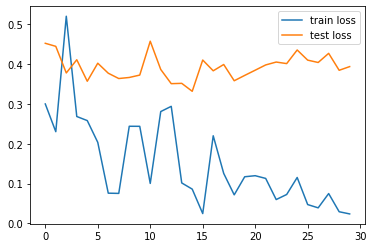

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()

if not training_process:
  # Re-load trained model
  my_classifier.load_state_dict(ckpt['my_classifier'])
  optimizer.load_state_dict(ckpt['optimizer'])

  # Testing
  n = 0.
  test_loss = 0.
  test_acc = 0.
  my_classifier.eval()
  for test_inputs, test_labels in test_dataloader:
    test_inputs = test_inputs.to(device)
    test_labels = test_labels.to(device)

    logits = my_classifier(test_inputs)
    test_loss += F.cross_entropy(logits, test_labels, reduction='sum').item()
    test_acc += (logits.argmax(dim=1) == test_labels).float().sum().item()
    n += test_inputs.size(0)

  test_loss /= n
  test_acc /= n
  print('Test_loss : {:.4f}, Test accuracy : {:.4f}'.format(test_loss, test_acc))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label : cat
prediction : cat


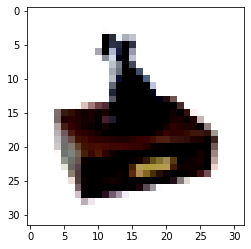

In [ ]:
import random

import matplotlib.pyplot as plt
import numpy as np

my_classifier.eval()

num_test_samples = len(test_dataset)
random_idx = random.randint(0, num_test_samples)

test_input, test_label = test_dataset.__getitem__(random_idx)
test_prediction = F.softmax(my_classifier(test_input.unsqueeze(0).to(device)), dim=1).argmax().item()
print('label : %s' % classes[test_label])
print('prediction : %s' % classes[test_prediction])

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# show images
imshow(torchvision.utils.make_grid(test_input))

# <font color="cyan"> Discussion and Analysis </font>

<font color="cyan"> 
- Train your CNN model and compare it to the baseline (in terms of training loss and the test accuracy).

Baseline Test Accuracy: <0.7 (30 epochs)

ResNet18 Test Accuracy: 0.91 (30 epochs)
- Explain your modifications and discuss how you improved the test accuracy.

Baseline Network is composed of a few convolutional layers. It is expected that there are fewer non-linearities and it may decrease the performance.

ResNet18 is a relatively deep network that is composed of 18 convolutional layers and each block contains a residual connection.

The main factors that improve the performance of the model are two things:

The first one is caused by the usage of a deeper model and residual block. We use a very deep network, so non-linearities are sufficiently applied to the model. Also, to prevent the model from being suffered from gradient vanishing, the model takes a residual shortcut and it makes the model being optimized easier.

The second one is data augmentation. Before we declare the dataloader for training data, we additionally use random crop and different normalization approaches of inputs for the transformation of the dataset. It helps to make the model generalized because the randomness from the input data is much more various than the original transformation.

</font>